This notebook can be used to run the optint experiment on a selected target intervention: change the target to the seleted population.

It can also be used to replicate **Fig. 6, S12-15**.

In [1]:
from generate import instance
from test import test_random, test_active
from argparse import Namespace
import numpy as np
import matplotlib.pyplot as plt

In [2]:
seed = 1234
np.random.seed(seed)

target = 'ptb_CDH19'
problem = instance(combination=False, seed=seed, target=f'{target}')

./data/estimated_dag.pkl
/home/vzhang/bayesian_mean_matching/perturb-CITE-seq/data/data+.pkl


### Fig. 6B: mean distance

In [7]:
distance = {}
for k in problem.int_pool.keys():
	distance[k] = np.linalg.norm(problem.int_pool[k][2] - problem.int_pool[target][2])**2

In [8]:
distance = {k: v for k, v in sorted(distance.items(), key=lambda item: item[1])}

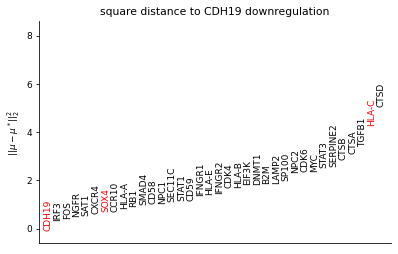

In [10]:
fig, ax = plt.subplots(figsize=(5.6,3.6))
plt.rc('font', size=9)
ax.scatter(range(36), list(distance.values()),s=0)

for i, txt in enumerate(distance.keys()):
	if txt == 'ptb_CDH19':
		color = 'red'
	elif txt in ['ptb_SOX4', 'ptb_HLA-C']:
		color = 'red'
	else:
		color = 'k'
	ax.annotate(txt.split('_')[1], (i, list(distance.values())[i]), rotation=90, color=color)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.ylim(-0.6,8.6)
plt.xlim(-0.5,36.5)
plt.xticks([])
plt.ylabel(r'$||\mu-\mu^*||_2^2$')
plt.title('square distance to CDH19 downregulation')
plt.tight_layout()
# plt.savefig('fig/rank-gene_SERPINE2-.pdf')

### creating anndata

In [11]:
col_labels  = [None]* 36
for k in problem.int_pool.keys():
	i = np.where(problem.int_pool[k][0] != 0)[0]
	col_labels[int(i)] = k.split('_')[1]

In [12]:
# idx = np.random.randint(len(problem.ctrl_samples.T), size=300)

# samples = problem.ctrl_samples.T[idx,:]
samples = problem.ctrl_samples.T
labels = np.array(['ctrl']*samples.shape[0])


for i, ptb in enumerate(problem.int_pool.keys()):
	samples = np.vstack((samples, problem.int_pool[ptb][3].T))
	labels = np.hstack((labels, [ptb]*problem.int_pool[ptb][1]))

In [13]:
import pandas as pd
import scanpy as sc

df = pd.DataFrame(samples, dtype=np.float32)
df.columns = col_labels
adata_new = sc.AnnData(df)
adata_new.obs['environments'] = labels

/home/vzhang/miniconda3/envs/ptbctseq/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


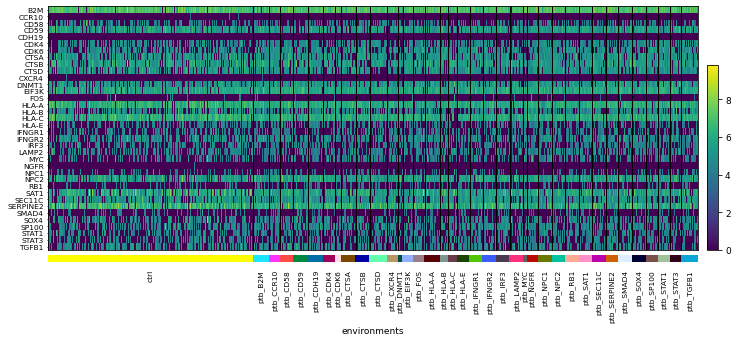

In [14]:
sc.pl.heatmap(adata_new, col_labels, groupby='environments',swap_axes=True, figsize=(12,4.8), save=False)

### Fig. S12: UMAP

In [15]:
samples = problem.ctrl_samples.T
labels = np.array(['ctrl']*samples.shape[0])

j = 'ptb_EIF3K'
for i, ptb in enumerate(problem.int_pool.keys()):
	# if i == 0:
	# 	samples = problem.int_pool[ptb][3].T
	# 	labels = np.array([ptb if i==j else 0]*problem.int_pool[ptb][1])
	# else:
	if ptb == j:
		samples = np.vstack((samples, problem.int_pool[ptb][3].T))
		labels = np.hstack((labels, [ptb if ptb==j else 'ptb others']*problem.int_pool[ptb][1]))

In [16]:
def filter(sample, ctrl_samples, idx):
	gene_pp = ctrl_samples[:, idx]
	gene = sample[idx]
	if len(np.where(gene_pp>=gene)[0])/len(gene_pp) >= 0:
		return True
	else:
		return False

samples = problem.ctrl_samples.T
labels = np.array(['ctrl']*samples.shape[0])

subset = ['ptb_CDH19', 'ptb_EIF3K','ptb_HLA-C', 'ptb_MYC', 'ptb_SERPINE2', 'ptb_TGFB1']
subset_plot = np.array([True]*samples.shape[0])

j = 'ptb_FOS'
for i, ptb in enumerate(problem.int_pool.keys()):
	# if i == 0:
	# 	samples = problem.int_pool[ptb][3].T
	# 	labels = np.array([ptb if i==j else 0]*problem.int_pool[ptb][1])
	# else:
	# if ptb == j:
	idx = list(problem.int_pool.keys()).index(j)
	for sample in  problem.int_pool[ptb][3].T:
		if filter(sample, problem.ctrl_samples.T, idx):
			samples = np.vstack((samples, sample))
			labels = np.hstack((labels, [ptb]))
			if ptb in subset:
				subset_plot = np.hstack((subset_plot, [True]))
			else:
				subset_plot = np.hstack((subset_plot, [False]))

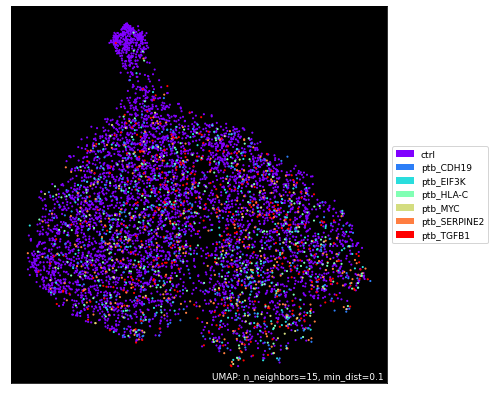

In [18]:
import umap
import umap.plot # edit umap.plot to alow for setting legend_bbox

mapper = umap.UMAP().fit(samples)

ax = umap.plot.points(mapper, labels=labels, theme='fire', legend_loc='center left', width=500, height=400, legend_bbox=(1,0.5), subset_points=subset_plot) #, show_legend=False)
plt.tight_layout()
# plt.savefig('figures/umap_all_tight.pdf')

### Fig. S14: violin plot

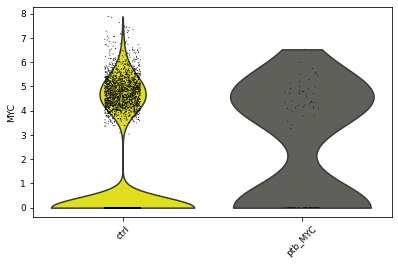

In [19]:
sc.pl.violin(adata_new, keys=['MYC'], groupby='environments', order = ['ctrl', 'ptb_MYC'], rotation=45, stripplot=True, save=False)

### Fig. 6A, S12B: contrastive PCA

In [20]:
import contrastive

In [21]:
int_samples = problem.int_pool[target][3].T
all_int_samples = None
plot_samples = problem.ctrl_samples.T
plot_labels = np.array(['ctrl'] * plot_samples.shape[0])

j = list(problem.int_pool.keys())
for i, ptb in enumerate(problem.int_pool.keys()):
	all_int_samples = problem.int_pool[ptb][3].T if all_int_samples is None else np.vstack([all_int_samples, problem.int_pool[ptb][3].T]) 
	if ptb in j:
		plot_samples = np.vstack((plot_samples, problem.int_pool[ptb][3].T))
		plot_labels = np.hstack((plot_labels, [ptb]*problem.int_pool[ptb][1]))

model = contrastive.CPCA()
proj_samples = model.fit_transform(all_int_samples, problem.ctrl_samples.T, alpha_selection='manual', alpha_value=0.66, return_alphas=True)

/home/vzhang/miniconda3/envs/ptbctseq/lib/python3.9/site-packages/contrastive/__init__.py:39: RuntimeWarning: invalid value encountered in true_divide
  standardized_array =  (array-np.mean(array,axis=0)) / np.std(array,axis=0)


In [22]:
def transform(data, model):
	sigma = model.fg_cov - 2.15 * model.bg_cov
	w, v = np.linalg.eig(sigma)
	eig_idx = np.argpartition(w, -2)[-2:]
	eig_idx = eig_idx[np.argsort(-w[eig_idx])]
	v_top = v[:,eig_idx]
	reduced_dataset = data.dot(v_top)
	reduced_dataset[:,0] = reduced_dataset[:,0]*np.sign(reduced_dataset[0,0])
	reduced_dataset[:,1] = reduced_dataset[:,1]*np.sign(reduced_dataset[0,1])
	return reduced_dataset

def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

/home/vzhang/miniconda3/envs/ptbctseq/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/vzhang/miniconda3/envs/ptbctseq/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/vzhang/miniconda3/envs/ptbctseq/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error o

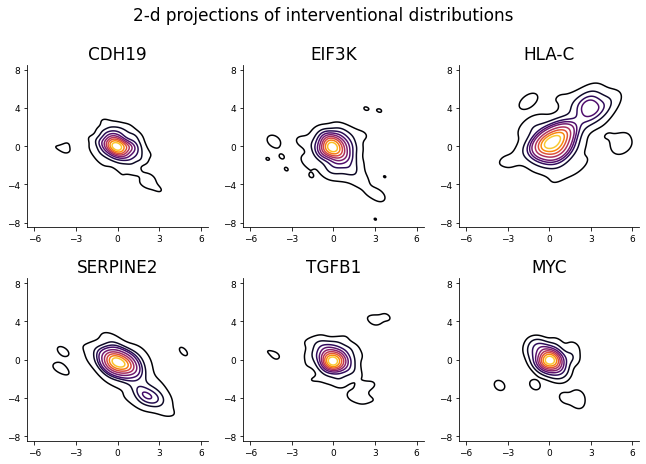

In [23]:
import seaborn as sns

r = transform(plot_samples, model)

fig, axs = plt.subplots(2,3,sharey=False, figsize=(9.2,6.6))
plt.rcParams.update({'font.size': 14})

for i,l in enumerate(['ptb_CDH19','ptb_EIF3K','ptb_HLA-C', 'ptb_SERPINE2', 'ptb_TGFB1', 'ptb_MYC']):
	idx = np.where(plot_labels==l)
	sns.kdeplot(r[idx,0].reshape(-1), r[idx,1].reshape(-1), n_levels=10, shade=False, ax=axs[int(i/3)][i%3], cmap='inferno'); #, alpha=0.5)
	axs[int(i/3)][i%3].set_title(l.split('_')[1])
	axs[int(i/3)][i%3].set_yticks([-8,-4,0,4,8])
	axs[int(i/3)][i%3].set_xticks([-6,-3,0,3,6])
	axs[int(i/3)][i%3].set_ylim(-8.5,8.5)
	axs[int(i/3)][i%3].set_xlim(-6.5,6.5)
	axs[int(i/3)][i%3].spines.right.set_visible(False)
	axs[int(i/3)][i%3].spines.top.set_visible(False)
	# axs[i].set_xticks([-4,-2,0,2,4])
	# axs[i].scatter(rand_jitter(r[idx,0]), rand_jitter(r[idx,1]), alpha=0.6, label=l, s=10, color='black')
fig.suptitle('2-d projections of interventional distributions')
plt.tight_layout()
# plt.savefig('figures/kde_more.pdf')

### Fig. 6C, S13, S15: run different methods

In [3]:
opts = Namespace(preprocess = 'nonzero', N0=100, N=10, T=10, unique=False)
R = 50

In [4]:
from tqdm import tqdm

A = []
Prob = []
for r in tqdm(range(R)):
	a, prob = test_random(problem, opts)
	A.append(a)
	Prob.append(prob)

opts.acq = 'civ'
opts.measure = 'unif'
A_0 = []
Prob_0 = []
for r in tqdm(range(R)):
	a, prob = test_active(problem, opts)
	A_0.append(a)
	Prob_0.append(prob)

opts.acq = 'greedy'
A_1 = []
Prob_1 = []
for r in tqdm(range(R)):
	a, prob = test_active(problem, opts)
	A_1.append(a)
	Prob_1.append(prob)

opts.acq = 'civ'
opts.measure = 'ow'
A_2 = []
Prob_2 = []
for r in tqdm(range(R)):
	a, prob = test_active(problem, opts)
	A_2.append(a)
	Prob_2.append(prob)

opts.acq = 'maxv'
A_3 = []
Prob_3 = []
for r in tqdm(range(R)):
	a, prob = test_active(problem, opts)
	A_3.append(a)
	Prob_3.append(prob)

opts.acq = 'cv'
A_4 = []
Prob_4 = []
for r in tqdm(range(R)):
	a, prob = test_active(problem, opts)
	A_4.append(a)
	Prob_4.append(prob)

100%|██████████| 50/50 [00:05<00:00,  8.57it/s]


<Figure size 432x288 with 0 Axes>

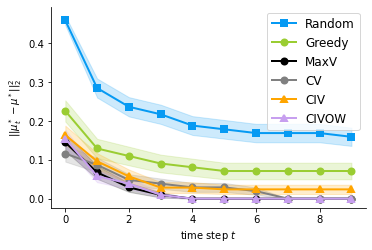

In [5]:
from plot import plot_mean

plot_mean(problem, opts, R, best=True, Random=Prob, Greedy=Prob_1, MaxV=Prob_3, CV=Prob_4, CIV=Prob_0, CIVOW=Prob_2)

# save_fig('fig/'+target.split('_')[1], 'mean-best.png')
try:
	target = target.split('_')[1]
except IndexError:
	target = target
# plt.savefig('figures/mse-mu_{}_full.pdf'.format(target))

<Figure size 432x288 with 0 Axes>

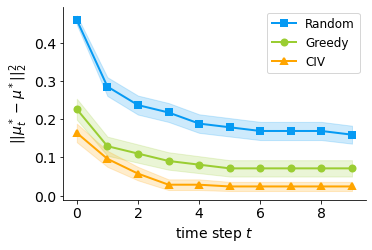

In [6]:
plot_mean(problem, opts, R, best=True, Random=Prob, Greedy=Prob_1, CIV=Prob_0)

# save_fig('fig/'+target.split('_')[1], 'mean-best.png')
try:
	target = target.split('_')[1]
except IndexError:
	target = target
# plt.savefig('figures/mse-mu_{}_full.pdf'.format(target))